### Exploring Depression on Twitter

 Around 3 million Filipinos live with depression.  Arguing that social media is an alternative platform documenting daily life and thought patterns, In this project, we will explore tweets of Filipinos diagnosed with depression to identify changes in social media language and behavior that might signal the onset of a depressive episode.
 
 In this notebook, we will answer the three questions:
 - How often they tweet?
 - What time do they tweet?
 - What are the topics of their tweets?

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

%matplotlib inline

#### Import dataset

In [220]:
df = pd.read_csv('TWEETS_OF_USERS_WITH_DEPRESSION_FINAL.csv', sep = '\t')

/home/carlo/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,1,2,9,10,16,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [221]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'timezone', 'place',
       'tweet', 'hashtags', 'cashtags', 'user_id', 'user_id_str', 'username',
       'name', 'day', 'hour', 'link', 'retweet', 'nlikes', 'nreplies',
       'nretweets', 'quote_url', 'search', 'near', 'geo', 'source',
       'user_rt_id', 'user_rt', 'retweet_id', 'reply_to', 'retweet_date'],
      dtype='object')

#### Get list of users diagnosed with depression

In [223]:
df1 = df[['username', 'tweet', 'date']]
flag = pd.read_excel('FLAGGING_POSITIVES(1).xlsx')
df2 = flag[['username', 'date', 'user_has_depression']]
df2 = df2[df2['user_has_depression']=='y']

We have 97 users diagnosed with depression

In [224]:
len(df['username'].unique())

97

In [225]:
df2 = df2.drop('user_has_depression',axis=1)

In [226]:
df2.columns = ['username', 'date_diagnosed']

In [227]:
df3 = pd.merge(df1, df2, on='username')

In [228]:
df3[['tweet', 'date', 'date_diagnosed']].head(10)

,tweet,date,date_diagnosed
0,You're welcome. Enjoy your special day 😁,2019-11-13 12:30:11,2019-04-17 01:22:59
1,Probably there is something bothering you,2019-11-12 22:50:19,2019-04-17 01:22:59
2,How to subscribe po??,2019-11-09 09:50:29,2019-04-17 01:22:59
3,How to subscribe po,2019-11-09 09:43:48,2019-04-17 01:22:59
4,Hugs,2019-11-06 14:15:48,2019-04-17 01:22:59
5,Wanna to watch the full video,2019-11-06 09:04:24,2019-04-17 01:22:59
6,Just posted a photo https://www.instagram.com...,2019-11-01 13:20:58,2019-04-17 01:22:59
7,On my way home,2019-10-30 10:42:05,2019-04-17 01:22:59
8,You're welcome 😉,2019-10-19 00:58:40,2019-04-17 01:22:59
9,Good luck and do your best. Aja!,2019-10-14 12:38:36,2019-04-17 01:22:59


In [230]:
data=df3[['tweet', 'username', 'date', 'date_diagnosed']]

In [231]:
# remove anomalous data 
data = data[data['date']!='189451415']
data = data[data['date']!='2935747158']

# convert date object to datetime
data["date"] = pd.to_datetime(data["date"],  format='%Y%m%d %H:%M:%S')
data["date_diagnosed"] = pd.to_datetime(data["date_diagnosed"],  format='%Y%m%d %H:%M:%S')

# extract date from the datetime object
data['hour'] = data['date'].dt.hour
data['month'] = data['date'].dt.month
data['date'] = data['date'].dt.date

data['month_diagnosed'] = data['date_diagnosed'].dt.month
data['date_diagnosed'] = data['date_diagnosed'].dt.date

# data['expand'] = data.apply(lambda x: ','.join([str(x['tweet'])]), axis=1)
# data = data.groupby(['username'])['expand'].apply(list)

In [232]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})


#### Number of tweets across the years

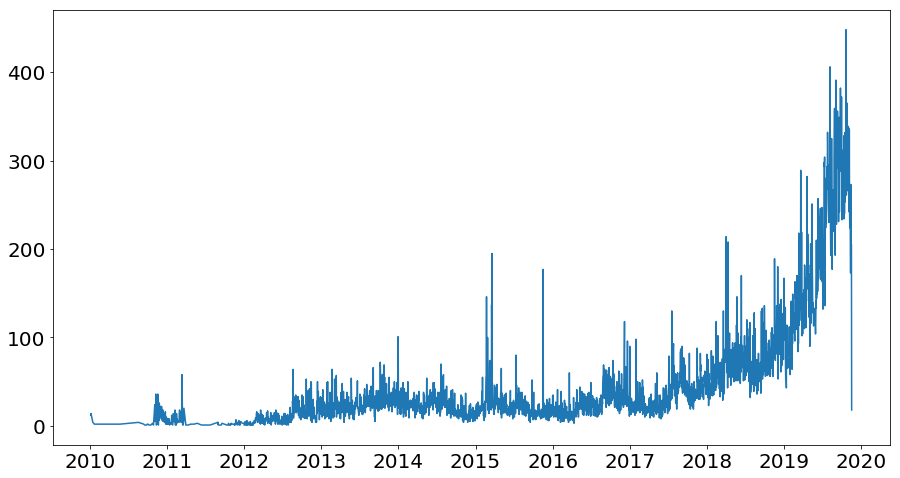

In [233]:
plt.figure(figsize=(15,8))
plt.plot(data['date'].value_counts().sort_index())

#### Most of the tweets from the dataset have different years ranging from 2011-2019. So I decided to group the tweets into months relative to the month before they were diagnosed

## How Often they Tweet?

In this plot, we can see that as they approach the depressive month, their tweets suddenly increase.

In [234]:
data['difference'] = data['month'] - data['month_diagnosed']

In [235]:
months_relative_to_diagnosed = data[(data['difference'] >= 0) & (data['difference'] <= 6)]

Text(0.5,1,'Number of Tweets before Diagnosed with Depression')

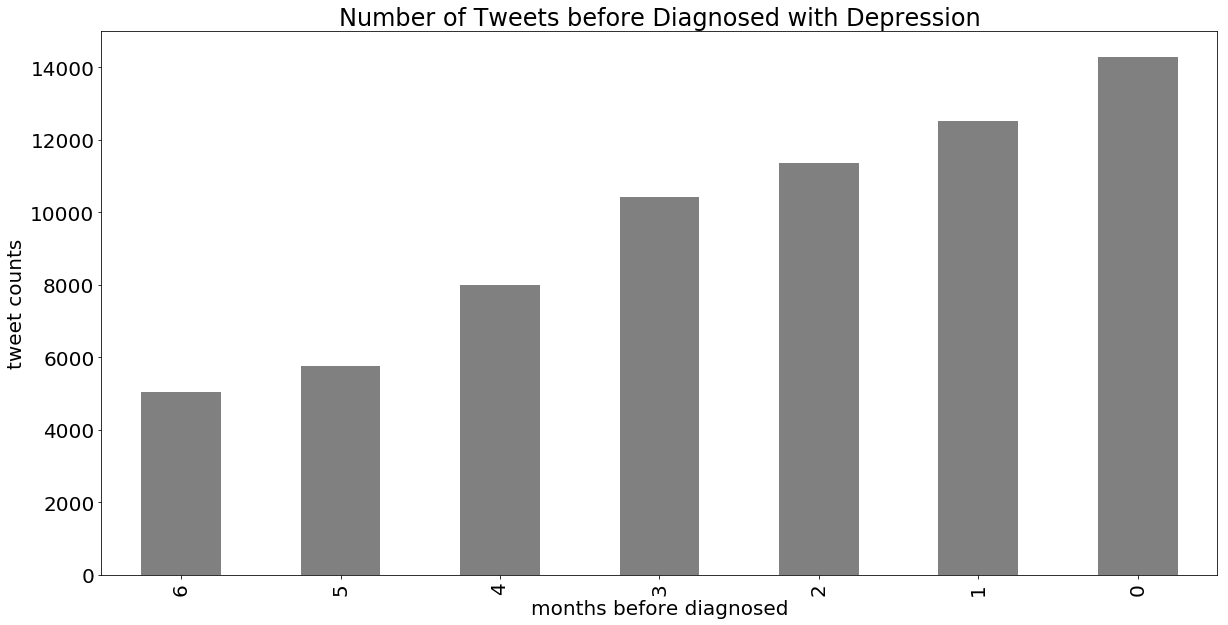

In [236]:
months_relative_to_diagnosed['difference'].value_counts().sort_index(ascending=False).plot(kind = 'bar', figsize=(20,10), color='gray')
plt.xlabel('months before diagnosed')
plt.ylabel('tweet counts')
plt.title('Number of Tweets before Diagnosed with Depression')

## When they tweet?

As you can see in the plot below, most depressed users tweet at 10-11pm


Text(0.5,1,'Number of tweets across the day')

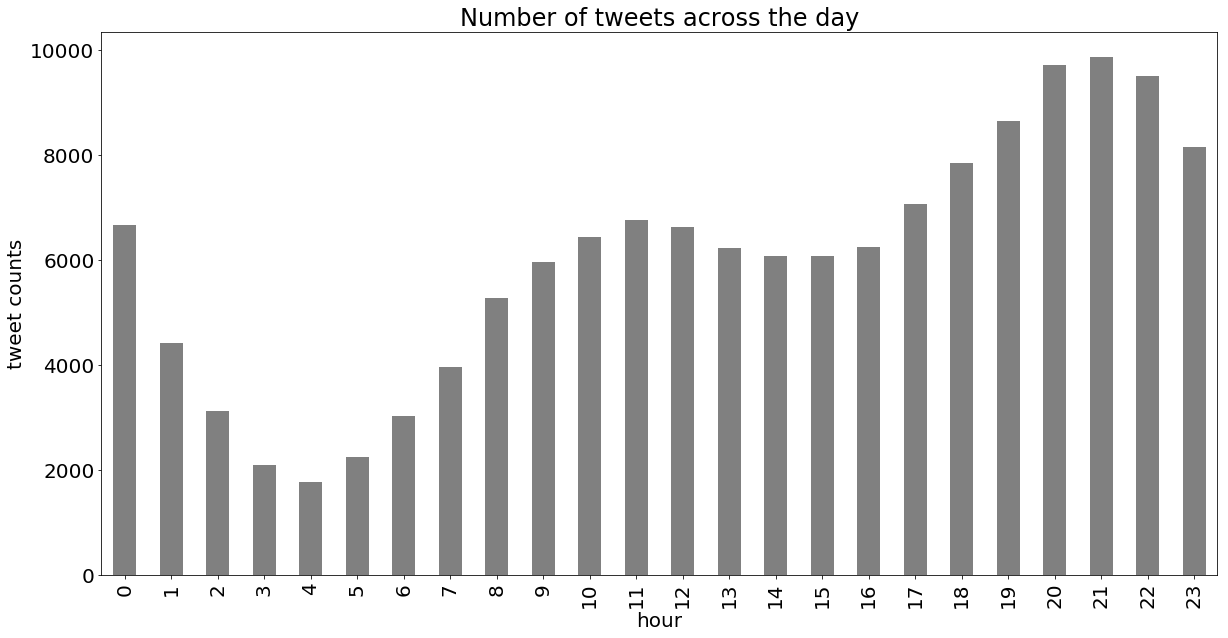

In [237]:
data['hour'].value_counts().sort_index(ascending=True).plot(kind = 'bar', figsize=(20,10), color='gray')
plt.xlabel('hour')
plt.ylabel('tweet counts')
plt.title('Number of tweets across the day')

## What are the topics they are tweeting about?

##### Next, we will explore if there is a difference in their language behavior from 6 months, 3 months and 1 month before they were diagnosed with depression. 


In [238]:
from dateutil.relativedelta import relativedelta

# 6months
date_minus_6months = data['date_diagnosed'] - relativedelta(months=6)
data_6months = data[(data['date']<data['date_diagnosed']) & (data['date']>date_minus_6months)]

# 3months
date_minus_3months = data['date_diagnosed'] - relativedelta(months=3)
data_3months = data[(data['date']<data['date_diagnosed']) & (data['date']>date_minus_3months)]

# 1month
date_minus_1month = data['date_diagnosed'] - relativedelta(months=1)
data_1month = data[(data['date']<data['date_diagnosed']) & (data['date']>date_minus_1month)]

### Data Preprocessing

In [239]:
with open('tagalog-stopwords-latest.txt', 'r') as f:
    tagalog_stopwords = f.read().splitlines()

In [242]:
from sklearn.feature_extraction import text 
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# As I trained the model, I added stop words that don't add meaning to the topics
stop_words.extend([
    'amp','get','got','hey','hmm','hoo','hop','iep','let','ooo','par', 'tapos', 'ganyan', 'kayo', 'daw', 'parang', 'hirap', 'tangina', 'wag', 'pip', 'wala', 'jowa', 'puta',
    'pdt','pln','pst','wha','yep','yer','aest','didn','nzdt','via', 'eto', 'ayie', 'nalang', 'akala', 'bb', 'charot', 'oof', 'sobrang', 'sobra', 'di', 'rh', 'nwala', 'mahal',
            'one','com','new','like','great','make','top','awesome','best', 'ipagmamalaki', 'kamo', 'shookt', 'lodi', 'ulit', 'month', 'day', 'year', 'weak', 'yun', 'muna', 'rn', 'huhu', 'dis', 'saya',
            'good','wow','yes','say','yay','would','going', 'nme', 'nwe', 'kita', 'hr', 'hrs', 'mtvstar', 'labyu', 'anyare','anong', 'hay', 'follower', 'unfollower',
            'new','use','should','could','best','really','see','want', 'nandito', 'lagi', 'putangina', 'morning', 'birthday', 'today', 'wanna', 'week', 'twitter',
            'direction','lyric','dreamboy', 'daming', 'kang', 'pagod', 'aga', 'tweet', 'fb',
            'while','know', 'from', 'subject', 're', 'edu', 'use', 'masusunod','dinala', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'rt', 'dm', 'ba', 'nag', 'nya', 'jusko', 'basta', 'hmmm', 'mahirap','malalagpasan','namamalayan','kna','pala', 'bfcbv', 'pilipina', 'kasi', 'sana', 'sarap', 'sauna', 'tho', 'taas','nga','kamay','kundi', 'anak', 'lol', 'chos', 'themorningrush', 'nowlistening', 
    'omg','from', 'subject', 're', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'see', 'rather', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'huh', 'po', 'uy', 'sinasabi', 'rt', 'dm', 'ba', 'nag', 'nya', 'jusko', 'basta', 'hmmm', 'mahirap','malalagpasan','namamalayan','kna','pala', 'bfcbv', 'pilipina', 'kasi', 'sana', 'sarap', 'sauna', 'tho', 'taas','nga','kamay','kundi', 'anak', 'lol', 'chos', 'themorningrush', 'bcoz', 'aww', 'nowlistening','today', 'yesterday', 'happy_birthday', 'countonkobe', 'puta', 'birthday', 'twitter', 'coz', 'day', 'hour', 'month', 'bro', 'konting', 'year', 'week', 'tomorrow', 'dotaandboy', 'ur','apexaward'])
stop_words.extend(tagalog_stopwords)

# combine nltk and sklearn stop words
all_stop_words = text.ENGLISH_STOP_WORDS.union(stop_words)

### Tokenize sentence and clean

In [243]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub(r'\S*@\S*\s?', '', str(sent))  # remove emails
        sent = re.sub(r'\s+', ' ', sent)  # remove newline chars
        sent = re.sub(r"\'", "", sent)  # remove single quotes
        sent = re.sub(r'https:\/\/.*', '', sent)  # remove urls
        sent = re.sub(r'http:\/\/.*', '', sent)  # remove urls
        sent = re.sub(r'pic.twitter.com*', '', sent) # remove twitter pics url
        sent = re.sub(r'bit.ly*', '', sent) # remove bitly links
        sent = re.sub(r'@[A-Za-z0-9]+', '', sent) # remove twitter usernames
        
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [244]:
# convert to list

data6months = list(sent_to_words(data_6months.tweet.values.tolist()))
data3months = list(sent_to_words(data_3months.tweet.values.tolist()))
data1month = list(sent_to_words(data_1month.tweet.values.tolist()))


In [245]:
# %%time
import en_core_web_lg
nlp = en_core_web_lg.load(disable=['parser', 'ner'])

In [246]:
# create bigrams

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [247]:
%%time

def process_words(texts, stop_words=all_stop_words, allowed_postags=['NOUN', 'ADJ']):
    # remove stop words
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts_out = []
    
    # lemmatize
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    # remove stop words after lemmatize
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_6 = process_words(data6months)
data_3 = process_words(data3months)
data_1 = process_words(data1month)


CPU times: user 5min 57s, sys: 3.3 s, total: 6min
Wall time: 12min 28s


In [254]:
from collections import defaultdict


def keep_relevant_words(data):
    
    token_frequency = defaultdict(int)

    # count all token
    for doc in data:
        for token in doc:
            token_frequency[token] += 1

    # keep words that occur more than twice
    documents = [[token for token in doc if token_frequency[token] > 2] for doc in data]

    # keep only documents with greater than 5 words
    documents = [doc for doc in documents if len(doc) > 5]
    
    return documents

In [231]:
# sorted(token_frequency.items(), key=lambda item: item[1], reverse=True)

In [259]:
doc6 = keep_relevant_words(data_6)
doc3 = keep_relevant_words(data_3)
doc1 = keep_relevant_words(data_1)


In [261]:
# create dictionary
id2word_6months = corpora.Dictionary(doc6)
id2word_3months = corpora.Dictionary(doc3)
id2word_1month = corpora.Dictionary(doc1)


# Create Corpus: Term Document Frequency
corpus_6months = [id2word_6months.doc2bow(text) for text in doc6]
corpus_3months = [id2word_3months.doc2bow(text) for text in doc3]
corpus_1month1 = [id2word_1month.doc2bow(text) for text in doc1]


### Topic Modeling using Latent Dirichlet Allocation(LDA)

In [337]:
def build_lda_model(corpus, id2word, num_topics):
    return gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=100,
                                           alpha='symmetric',
                                           iterations=200,
                                           per_word_topics=True)

In [264]:
lda_model_6months = build_lda_model(corpus_6months, id2word_6months, 30)

In [266]:
from pprint import pprint

pprint(lda_model_6months.show_topics())

[(10,
  '0.182*"bad" + 0.086*"post" + 0.081*"community" + 0.078*"comment" + '
  '0.060*"gender" + 0.056*"color" + 0.056*"level" + 0.037*"mad" + '
  '0.032*"account" + 0.032*"condition"'),
 (22,
  '0.262*"family" + 0.068*"second" + 0.062*"interesting" + 0.051*"happiness" + '
  '0.045*"equality" + 0.044*"sacrifice" + 0.043*"wonderful" + 0.024*"willing" '
  '+ 0.020*"slow" + 0.000*"mass"'),
 (16,
  '0.279*"true" + 0.084*"matter" + 0.059*"care" + 0.034*"success" + '
  '0.033*"counselor" + 0.033*"communication" + 0.031*"friendship" + '
  '0.020*"tip" + 0.018*"journey" + 0.002*"mile"'),
 (29,
  '0.313*"word" + 0.076*"fix" + 0.062*"area" + 0.046*"constant" + '
  '0.045*"stable" + 0.040*"fast" + 0.009*"path" + 0.000*"near" + '
  '0.000*"testing" + 0.000*"location"'),
 (18,
  '0.362*"way" + 0.228*"person" + 0.123*"hard" + 0.041*"insensitive" + '
  '0.007*"bullshit" + 0.000*"php" + 0.000*"technology" + 0.000*"reality" + '
  '0.000*"situation" + 0.000*"aspect"'),
 (13,
  '0.082*"idea" + 0.071*"mo

In [267]:
lda_model_3months = build_lda_model(corpus_3months, id2word_3months, 30)

In [268]:
pprint(lda_model_3months.show_topics())

[(23,
  '0.339*"kind" + 0.099*"issue" + 0.069*"heart" + 0.051*"important" + '
  '0.049*"sure" + 0.043*"place" + 0.032*"brand" + 0.025*"character" + '
  '0.021*"break" + 0.019*"political"'),
 (19,
  '0.108*"company" + 0.073*"article" + 0.063*"team" + 0.051*"order" + '
  '0.047*"private" + 0.042*"personal" + 0.040*"shame" + 0.038*"program" + '
  '0.038*"status" + 0.035*"large"'),
 (7,
  '0.225*"home" + 0.101*"treatment" + 0.086*"big" + 0.086*"game" + '
  '0.074*"free" + 0.029*"space" + 0.025*"step" + 0.022*"computer" + '
  '0.020*"change" + 0.019*"tip"'),
 (22,
  '0.127*"gender" + 0.101*"non" + 0.098*"depression" + 0.085*"color" + '
  '0.049*"discrimination" + 0.034*"animal" + 0.018*"violence" + '
  '0.010*"violent" + 0.007*"leg" + 0.006*"return"'),
 (12,
  '0.148*"self" + 0.092*"pain" + 0.083*"point" + 0.051*"tired" + '
  '0.048*"pressure" + 0.043*"area" + 0.042*"past" + 0.034*"care" + '
  '0.028*"wish" + 0.017*"energy"'),
 (15,
  '0.217*"guy" + 0.129*"family" + 0.082*"high" + 0.045*"fa

In [338]:
lda_model_1month = build_lda_model(corpus_1month1, id2word_1month, 20)
pprint(lda_model_1month.show_topics())

[(3,
  '0.067*"reason" + 0.046*"self" + 0.043*"single" + 0.042*"night" + '
  '0.035*"social" + 0.031*"low" + 0.029*"change" + 0.026*"sad" + '
  '0.023*"ticket" + 0.023*"choice"'),
 (9,
  '0.161*"issue" + 0.078*"boy" + 0.074*"different" + 0.058*"late" + '
  '0.055*"solution" + 0.051*"crime" + 0.036*"bathroom" + 0.035*"problem" + '
  '0.033*"podcast" + 0.026*"rape"'),
 (4,
  '0.180*"thing" + 0.047*"article" + 0.045*"world" + 0.039*"water" + '
  '0.036*"deep" + 0.034*"faith" + 0.031*"work" + 0.024*"note" + '
  '0.023*"advocacy" + 0.020*"demand"'),
 (0,
  '0.189*"woman" + 0.136*"man" + 0.064*"fact" + 0.025*"process" + '
  '0.023*"character" + 0.023*"science" + 0.023*"sex" + 0.021*"discussion" + '
  '0.021*"special" + 0.020*"cost"'),
 (15,
  '0.141*"school" + 0.120*"parent" + 0.103*"shift" + 0.040*"talk" + '
  '0.009*"psychology" + 0.009*"transfer" + 0.001*"attendance" + 0.001*"card" + '
  '0.001*"quarter" + 0.001*"bid"'),
 (18,
  '0.083*"rest" + 0.049*"calm" + 0.048*"little" + 0.047*"step"

In [325]:
# import pyLDAvis.gensim
# pyLDAvis.enable_notebook()

# # vis6 = pyLDAvis.gensim.prepare(lda_model_6months, corpus_6months, dictionary=lda_model_6months.id2word)
# # vis3 = pyLDAvis.gensim.prepare(lda_model_3months, corpus_3months, dictionary=lda_model_3months.id2word)
# # vis1 = pyLDAvis.gensim.prepare(lda_model_1month, corpus_1month1, dictionary=lda_model_1month.id2word)

#### Visualizing the Topic models

Next, we will visualize the output and results from topic model (LDA).

In [319]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors



def show_word_cloud(lda_model):

    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False)

    fig, axes = plt.subplots(5, 2, figsize=(18,14), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()):

        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=420)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

#### Topic model of 6 months before diagnosed

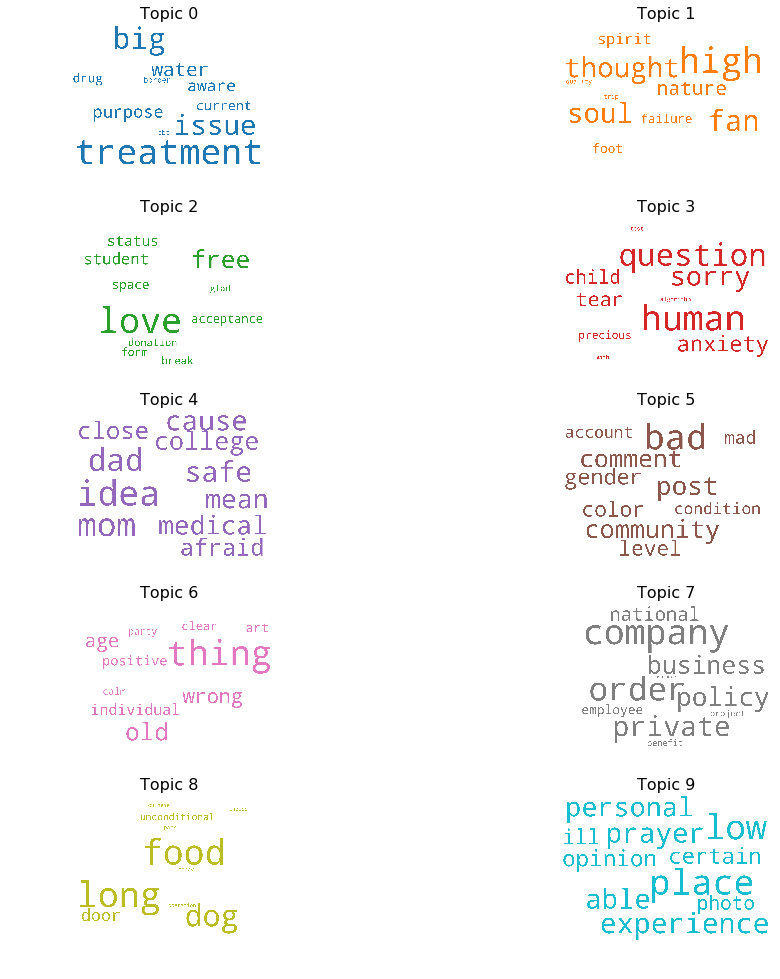

In [320]:
show_word_cloud(lda_model_6months)

#### Topic model of 3 months before diagnosed

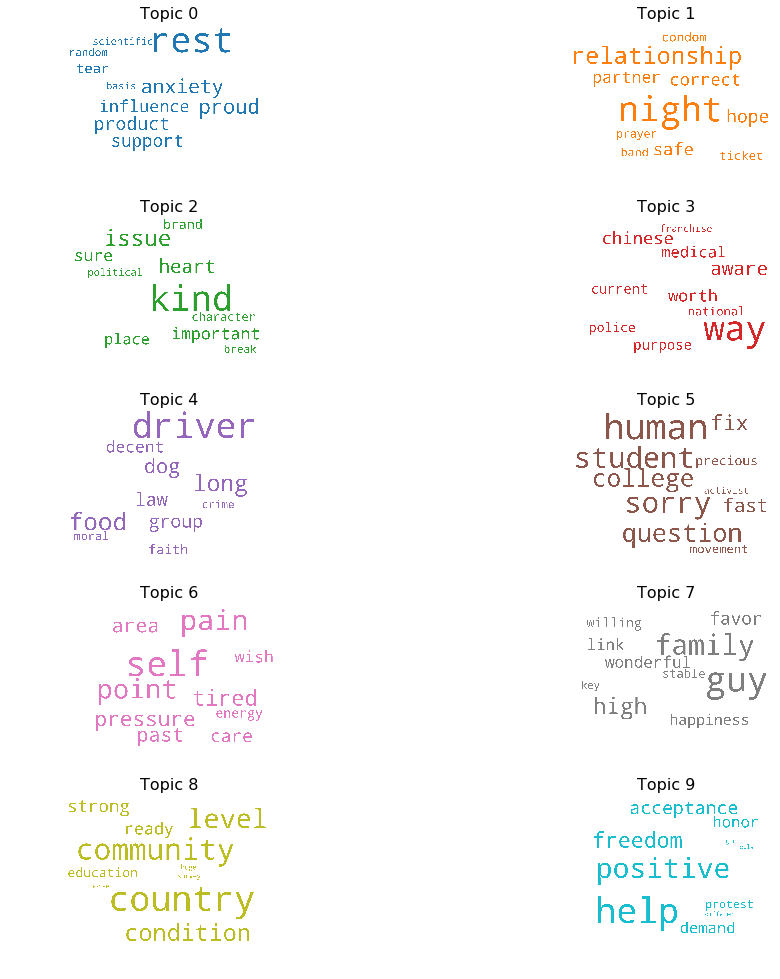

In [322]:
show_word_cloud(lda_model_3months)

#### Topic model of 1 month before diagnosed

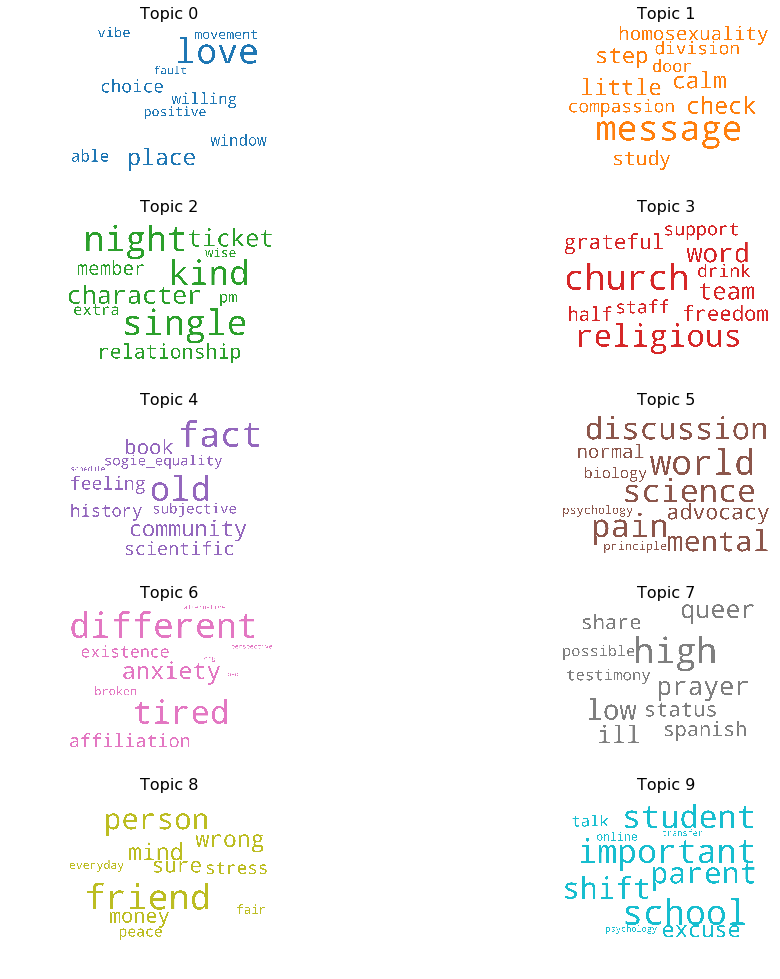

In [331]:
show_word_cloud(lda_model_1month)

#### Conclusion:

In this notebook, we explored the tweets of users diagnosed with depression, and answered the questions:

- How often they tweet?
    - We found out that as they approach the depressive episode, their tweets started to increase.
    
- When they tweet?
    - The number of tweets peak at night, around 11pm. There's a research paper that says Insomnia and sleep disturbance is often a    symptom of mental health disorders (Weissman et al., 1996; De Choudhury et al, 2013)


- What are the topics of their tweet?
    - As they approach the depressive episode, they started to talk topics about anxiety, religion, pain etc. 



#### What's Next?

- Find more markers
- Include tagalog tweets
- Create a predictive model
- Get more data